In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

from sklearn.metrics.pairwise import pairwise_distances 

data_path = '../data/21B_tag_views_dataset.csv'

### Data loading and initial verifications

In [2]:
data = pd.read_csv(data_path, encoding='utf8')

In [3]:
data.head()

,id,user_id,tag_id,product_name
0,1,00000055a78bf6735c4a89358fab1de34104c3cb,e78de9dad70d230a096f0bbdc3e89b5cae04ba77,La Gar̤onne In Oro Rosa A Maglie/bianco
1,2,00000055a78bf6735c4a89358fab1de34104c3cb,b9a521730141de9bc4fe8ebc9f33713411d0101a,Fishnet Eco Bag
2,3,00000055a78bf6735c4a89358fab1de34104c3cb,8378136c6dd0e03be859a210a0cee03955951fb1,Collarino Essentielle In Oro Interamente A Esa...
3,4,00000055a78bf6735c4a89358fab1de34104c3cb,9cc68d8345f675892bcab0fad02f65b4ac7e71ea,Asos - Vestito A Fascia Con Fondo A Fisarmonica
4,5,00000055a78bf6735c4a89358fab1de34104c3cb,a8272c62cd05d5b882e4f630fb55cfa0ba8491e6,Peggy Off Shoulder Corset Top-white


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 4 columns):
id              9999 non-null int64
user_id         9999 non-null object
tag_id          9999 non-null object
product_name    9999 non-null object
dtypes: int64(1), object(3)
memory usage: 312.5+ KB


In [5]:
data.isnull().sum() # Checking for null data

id              0
user_id         0
tag_id          0
product_name    0
dtype: int64

## Simple explorative analysis

In [6]:
data = data.set_index("id")

In [7]:
data.head()

,user_id,tag_id,product_name
id,,,
1,00000055a78bf6735c4a89358fab1de34104c3cb,e78de9dad70d230a096f0bbdc3e89b5cae04ba77,La Gar̤onne In Oro Rosa A Maglie/bianco
2,00000055a78bf6735c4a89358fab1de34104c3cb,b9a521730141de9bc4fe8ebc9f33713411d0101a,Fishnet Eco Bag
3,00000055a78bf6735c4a89358fab1de34104c3cb,8378136c6dd0e03be859a210a0cee03955951fb1,Collarino Essentielle In Oro Interamente A Esa...
4,00000055a78bf6735c4a89358fab1de34104c3cb,9cc68d8345f675892bcab0fad02f65b4ac7e71ea,Asos - Vestito A Fascia Con Fondo A Fisarmonica
5,00000055a78bf6735c4a89358fab1de34104c3cb,a8272c62cd05d5b882e4f630fb55cfa0ba8491e6,Peggy Off Shoulder Corset Top-white


Top seen products descriptions

In [8]:
data['product_name'].value_counts()

Look                                                                            240
501� Shorts                                                                     124
Shiny Moon Necklace - Maria Pascual Shop                                        111
Zapatillas Converse Chuck Taylor All Star Lift High Top                          66
Ba̱ador Madeira                                                                  62
Chaqueta Cropped                                                                 61
Vestido                                                                          60
Mono Corto Pinzas                                                                59
Line Black                                                                       59
Vestido Camisero Estampado Serpiente                                             55
Minivestido Skater Con Bordados Y Espalda Abierta De A Star Is Born              53
Vestido Largo Estampado Animal                                              

Verify that descriptions are not unique to the tags:

In [9]:
data.groupby('product_name')['tag_id'].nunique()

product_name
(similar) 'equador' Gold Lurex Tie Side Bikini Two Piece                     2
(similar) Bandolera De Piel De Becerro                                       1
(similar) Falda Asim̩trica Con Volantes                                      1
(simile) Limoncello                                                          1
1950's 701 Cut Off Shorts                                                    2
501 Customized High Rise Short                                               3
501 High Rise Short                                                          1
501� Shorts                                                                 12
501� Skinny Jeans                                                            1
A.bing Shorts                                                                1
Abito Avvolgente Con Stampa Botanica A Volant                                1
Abito Bianco A Quadri                                                        1
Abrigo Jacquard Special Garment        

As stated, there are descriptions that map to multiple tags.

Letssee the distribution of tags by user:

In [10]:
tag_df = data.groupby(['user_id']).agg({'tag_id': 'count'}).rename({'tag_id':'tag_count'})
tag_df.head()

,tag_id
user_id,
00000055a78bf6735c4a89358fab1de34104c3cb,8
00000bfd1cce5d57bd67ca12b70acc8cd4df4176,2
000014674d2afbd30b4a89e7f917b67ade3c31c4,9
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,3
00002d886b0027b4cead503a8a6f71b797721dcc,1


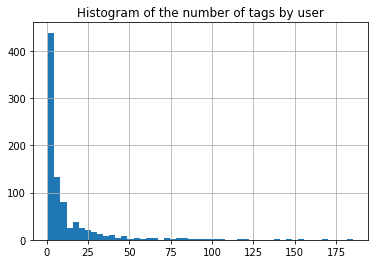

In [11]:
tag_df.hist(bins=50)
plt.title('Histogram of the number of tags by user')
plt.show()

Most of the users have few tags, however there are some heavy users:

In [12]:
tag_df[tag_df['tag_id'] > 50].count()

tag_id    37
dtype: int64

On average each user has ~12 tags:

In [13]:
tag_df['tag_id'].mean()

11.640279394644937

### Data preparation

In [14]:
tag_count_df = data.groupby(['user_id', 'tag_id']).agg({'tag_id': 'count'}).rename(columns={'tag_id':'tag_count'})
tag_count_df.head()

tag_count
user_id                                  tag_id                                             
00000055a78bf6735c4a89358fab1de34104c3cb 5c61cd1b82ec7a4d2918a6de99fcd1577b462f79          1
                                         8378136c6dd0e03be859a210a0cee03955951fb1          1
                                         9cc68d8345f675892bcab0fad02f65b4ac7e71ea          1
                                         a1437d6393ee9535248b16f27a649bbd98c9e2f5          1
                                         a8272c62cd05d5b882e4f630fb55cfa0ba8491e6          1

Guarantee that the tags are one for each user, otherwise we could normlize the values:

In [15]:
tag_count_df[tag_count_df['tag_count'] > 1]

,,tag_count
user_id,tag_id,


In [16]:
tag_count_df = tag_count_df.reset_index()
user_products_df = tag_count_df.pivot(index='user_id', columns='tag_id', values='tag_count')

In [17]:
user_products_df.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
user_id,,,,,,,,,,,,,,,,,,,,,
00000055a78bf6735c4a89358fab1de34104c3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000bfd1cce5d57bd67ca12b70acc8cd4df4176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000014674d2afbd30b4a89e7f917b67ade3c31c4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00002d886b0027b4cead503a8a6f71b797721dcc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
user_products_df = user_products_df.fillna(0)

In [19]:
user_products_df.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
user_id,,,,,,,,,,,,,,,,,,,,,
00000055a78bf6735c4a89358fab1de34104c3cb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000bfd1cce5d57bd67ca12b70acc8cd4df4176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000014674d2afbd30b4a89e7f917b67ade3c31c4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00002d886b0027b4cead503a8a6f71b797721dcc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Collaborative Engine using matrix decomposition

In [20]:
user_views_m = user_products_df.values

In [21]:
n_factors = 30

In [22]:
u, sigma, v = svds(user_views_m, k=n_factors)

In [23]:
sigma.shape

(30,)

In [24]:
sigma = np.diag(sigma)

In [25]:
user_predictions = np.dot(np.dot(u, sigma), v)

In [26]:
user_predictions[5]

array([ 1.17608699e-01, -1.37340668e-02,  5.47159212e-02,  5.68197919e-02,
       -8.89242324e-03, -7.49724901e-02,  4.10587475e-02,  1.32804455e-01,
       -1.20318387e-02,  7.10792648e-02, -9.72986256e-02, -1.86331745e-03,
        3.34355950e-02,  1.99222418e-02,  1.35276098e-01, -5.46985882e-02,
       -2.33363139e-02, -6.11600466e-03, -3.79915088e-02, -1.48698895e-04,
        9.48674178e-03, -2.27511947e-03, -6.82499812e-02,  8.62263572e-02,
        1.87526203e-01, -3.32287443e-02,  4.18772405e-01,  3.07193232e-03,
       -1.46672571e-02,  1.30282169e-01, -4.84801182e-02, -5.49624160e-03,
        1.10764218e-01,  2.45455790e-02, -4.97353583e-02,  5.11412873e-02,
        3.09208629e-02,  7.31227067e-02,  1.01313120e-03, -1.04630818e-01,
        2.42423526e-01,  4.42583032e-02,  4.87013487e-04, -4.19613394e-02,
       -7.73241398e-03, -8.78482586e-03, -6.03526953e-02,  7.93005063e-03,
       -3.45188933e-02, -8.26223997e-03,  3.11515958e-02, -4.27587568e-06,
        4.40939782e-02,  

In [27]:
predictions_df = pd.DataFrame(user_predictions, columns=user_products_df.columns, index=user_products_df.index)

In [28]:
predictions_df.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
user_id,,,,,,,,,,,,,,,,,,,,,
00000055a78bf6735c4a89358fab1de34104c3cb,-0.014866,0.060836,-0.017110,0.003044,0.011555,0.006090,0.000554,-0.005222,0.016631,-0.005451,...,0.000748,0.000596,-0.009415,-0.006249,0.002843,0.013700,0.005257,0.012079,0.036071,-0.001170
00000bfd1cce5d57bd67ca12b70acc8cd4df4176,0.001181,0.001905,0.011497,0.004006,-0.000412,0.001461,-0.000271,0.000884,-0.000876,-0.004407,...,0.008146,0.001156,-0.002484,-0.001193,0.000885,-0.001368,-0.000885,0.004652,0.000793,0.001729
000014674d2afbd30b4a89e7f917b67ade3c31c4,-0.000810,0.013074,0.017521,0.006806,-0.003932,-0.001724,-0.001635,0.001399,-0.000433,-0.007106,...,0.015827,0.004245,-0.006307,-0.003825,0.001044,-0.005512,-0.003172,0.010548,-0.002629,0.003238
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,-0.011246,-0.000351,-0.002646,-0.008326,0.005049,-0.009038,0.006512,0.009436,-0.008576,0.007564,...,0.000281,-0.004248,0.003945,-0.004988,-0.001751,0.008214,0.014459,-0.000424,-0.020823,-0.000095
00002d886b0027b4cead503a8a6f71b797721dcc,-0.005333,-0.000009,-0.003110,0.000677,0.000509,-0.006629,-0.001055,-0.002967,0.002435,0.000080,...,0.000093,0.000776,-0.002866,0.000575,-0.002378,0.002038,-0.000615,0.000540,-0.002101,-0.000005


### User most similar products

In [29]:
user = '00000055a78bf6735c4a89358fab1de34104c3cb'  # First user

In [30]:
top_n = 10  # Number of predictions to get

In [31]:
user_predictions = predictions_df.loc[user].sort_values(ascending=False).reset_index()

In [32]:
user_predictions.head()

,tag_id,00000055a78bf6735c4a89358fab1de34104c3cb
0,778e3136ca5764da2281b4de5712693c5523155d,0.121774
1,e531c1dad33434c9d7a323f7928cae9cf04f9f7a,0.115628
2,3e4d8d24daf15692515999d4c8809eac1a3ee55c,0.108170
3,5d39b3d82fb38bb63c169307b29f8c065f5069e1,0.105608
4,a914d369f870385007a5d937c19753f5fd55692d,0.102858


In [33]:
user_products_df.loc[user].index[user_products_df.loc[user]>0]

Index(['5c61cd1b82ec7a4d2918a6de99fcd1577b462f79',
       '8378136c6dd0e03be859a210a0cee03955951fb1',
       '9cc68d8345f675892bcab0fad02f65b4ac7e71ea',
       'a1437d6393ee9535248b16f27a649bbd98c9e2f5',
       'a8272c62cd05d5b882e4f630fb55cfa0ba8491e6',
       'b9a521730141de9bc4fe8ebc9f33713411d0101a',
       'c093b1743115b3f9d368b2f7bdf54f367afccc7c',
       'e78de9dad70d230a096f0bbdc3e89b5cae04ba77'],
      dtype='object', name='tag_id')

### User most similar products which weren't seen by the user

In [34]:
user_seen_products = data[data['user_id']==user]['tag_id']
user_seen_products

id
1    e78de9dad70d230a096f0bbdc3e89b5cae04ba77
2    b9a521730141de9bc4fe8ebc9f33713411d0101a
3    8378136c6dd0e03be859a210a0cee03955951fb1
4    9cc68d8345f675892bcab0fad02f65b4ac7e71ea
5    a8272c62cd05d5b882e4f630fb55cfa0ba8491e6
6    5c61cd1b82ec7a4d2918a6de99fcd1577b462f79
7    c093b1743115b3f9d368b2f7bdf54f367afccc7c
8    a1437d6393ee9535248b16f27a649bbd98c9e2f5
Name: tag_id, dtype: object

In [35]:
user_predictions[user_predictions['tag_id'].isin(user_seen_products)]

,tag_id,00000055a78bf6735c4a89358fab1de34104c3cb
7,9cc68d8345f675892bcab0fad02f65b4ac7e71ea,0.096682
18,a8272c62cd05d5b882e4f630fb55cfa0ba8491e6,0.078684
23,c093b1743115b3f9d368b2f7bdf54f367afccc7c,0.075883
29,b9a521730141de9bc4fe8ebc9f33713411d0101a,0.069433
43,e78de9dad70d230a096f0bbdc3e89b5cae04ba77,0.056374
44,8378136c6dd0e03be859a210a0cee03955951fb1,0.055725
158,a1437d6393ee9535248b16f27a649bbd98c9e2f5,0.013936
390,5c61cd1b82ec7a4d2918a6de99fcd1577b462f79,0.003727


In [36]:
not_seen_user_preds = user_predictions[~user_predictions['tag_id'].isin(user_seen_products)]
not_seen_user_preds.head()

,tag_id,00000055a78bf6735c4a89358fab1de34104c3cb
0,778e3136ca5764da2281b4de5712693c5523155d,0.121774
1,e531c1dad33434c9d7a323f7928cae9cf04f9f7a,0.115628
2,3e4d8d24daf15692515999d4c8809eac1a3ee55c,0.108170
3,5d39b3d82fb38bb63c169307b29f8c065f5069e1,0.105608
4,a914d369f870385007a5d937c19753f5fd55692d,0.102858


Lets have a look at the descriptions of the products seen by this user:

In [37]:
data[data['user_id']==user]['product_name'].values

array(['La Gar̤onne In Oro Rosa A Maglie/bianco', 'Fishnet Eco Bag',
       'Collarino Essentielle In Oro Interamente A Esagoni',
       'Asos - Vestito A Fascia Con Fondo A Fisarmonica',
       'Peggy Off Shoulder Corset Top-white',
       'Uo Suede Contrast Stitch Ecru Pelmet Skirt',
       'Shiny Moon Necklace - Maria Pascual Shop',
       "Maglione Jacquard Con Logo 'arantxa'"], dtype=object)

Get the top 10 user predictions for items he didn't see

In [38]:
top10_preds = not_seen_user_preds[:10]

A look at the descriptions of the recommendations:

In [39]:
data[data['tag_id'].isin(top10_preds['tag_id'])]['product_name'].unique()

array(['Bikini Perizoma Con Taglio Alto', 'Camicia Basic Lino',
       'Calypso Skirt', 'Calypso Top', 'Vestito A Tubo Con Volant',
       'Borsa A Tracolla Rotonda In Rafia', 'Bermuda Stampa Serpente',
       'Vg Incredible Girls Wrap Mini Dress', 'Bermuda Shorts A Righe',
       'Lorelai Midi Length Jacket-brown'], dtype=object)

In [40]:
user2 = user_products_df.index[1]

In [41]:
def get_user_predictions(user, predictions):
    user_predictions = predictions.loc[user].sort_values(ascending=False).reset_index()
    user_seen_products = data[data['user_id']==user]['tag_id']
    not_seen_user_preds = user_predictions[~user_predictions['tag_id'].isin(user_seen_products)]
    return not_seen_user_preds[:10]

In [42]:
user2_preds = get_user_predictions(user2, predictions_df)

In [43]:
data[data['tag_id'].isin(user2_preds['tag_id'])]['product_name'].unique()

array(['Reggiseno Triangolo In Pizzo Lisbon', 'Anello', 'Look',
       'Luxury Silver', 'T-shirt Yesterday Rainbow',
       'Mermaid Rarity Bikini Set', 'Costume Intero Elettra Nero',
       'Silk Crepon Top With Flounce On The Neckline - Flowers In Purple Water',
       'Camicetta Plissettata', 'Ariel'], dtype=object)

## Item Based Collaborative Filtering 

In [44]:
tags_user_df = tag_count_df.pivot(index='tag_id', columns='user_id', values='tag_count').fillna(0)
tags_user_df.head()

user_id,00000055a78bf6735c4a89358fab1de34104c3cb,00000bfd1cce5d57bd67ca12b70acc8cd4df4176,000014674d2afbd30b4a89e7f917b67ade3c31c4,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,00002d886b0027b4cead503a8a6f71b797721dcc,00009c599dca6873a47404fa9b7a9b0a1bd13049,0000a8c248465bc8cd907e112b5c2f1e94424f28,0000e13241f8b242a8a25666d488a7f8661112e2,0000e656186fd0eafc55ac7b9c109a0232cc6d49,0000e774b6e4c5df530c2dca979f8662ff695e07,...,005abc99490c8581a7d764236f0494af60853c97,005ac110b90e5a3d97391afef39c92309f4a609f,005ad182288447b6fd8774b2126551b7867ca00c,005ad88fd63284e847168b5719b99d90e6414bef,005b042fbb71e09988334dc2f200a971e0ce30ff,005b73371f07bd43ca9f824cd5de2f1a1d513201,005b90e15237bedb77b8e903a63f862aa3dcae34,005ba399f064ff0240a7aee3c659fae35ef2da43,005ba490ba9f4de4aeed34ae9500bfdc14014345,005c1ad3eb8ae0f1380e0116a4764ae97c6791ff
tag_id,,,,,,,,,,,,,,,,,,,,,
00410345e6d60633a211ebd3755d5c89ea7b5297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005703ee98894846cde759fbe88f3d7fde830c85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0076e2a45d90991150032dbfaa574b4b7ab21177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0087f6286f5bd4f872620555b3e3b880e21de444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
008a19c4e6b27ade78d422f9deaba16ef195772b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
item_similarity = pairwise_distances(tags_user_df.values, metric='cosine')
item_similarity.shape

(1000, 1000)

In [46]:
item_similarity = pd.DataFrame(item_similarity, columns=tags_user_df.index, index=tags_user_df.index)
item_similarity.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
tag_id,,,,,,,,,,,,,,,,,,,,,
00410345e6d60633a211ebd3755d5c89ea7b5297,0.000000,1.0,0.809307,1.0,1.000000,1.0,0.858579,0.891535,1.000000,0.741801,...,1.0,1.000000,0.870901,0.900000,1.0,1.000000,0.908713,1.000000,1.000000,1.0
005703ee98894846cde759fbe88f3d7fde830c85,1.000000,0.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0
0076e2a45d90991150032dbfaa574b4b7ab21177,0.809307,1.0,0.000000,1.0,0.876909,1.0,0.865160,0.844874,1.000000,0.876909,...,1.0,0.916376,0.876909,0.904654,1.0,0.893400,0.912961,1.000000,1.000000,1.0
0087f6286f5bd4f872620555b3e3b880e21de444,1.000000,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.923304,1.000000,1.000000,...,0.8,1.000000,1.000000,1.000000,1.0,1.000000,0.870901,0.817426,1.000000,1.0
008a19c4e6b27ade78d422f9deaba16ef195772b,1.000000,1.0,0.876909,1.0,0.000000,1.0,1.000000,0.929986,0.817426,1.000000,...,1.0,0.886772,1.000000,0.870901,1.0,0.711325,1.000000,1.000000,0.870901,1.0


In [47]:
item_similarity_dist = 1 - item_similarity
item_similarity_dist.head()

tag_id,00410345e6d60633a211ebd3755d5c89ea7b5297,005703ee98894846cde759fbe88f3d7fde830c85,0076e2a45d90991150032dbfaa574b4b7ab21177,0087f6286f5bd4f872620555b3e3b880e21de444,008a19c4e6b27ade78d422f9deaba16ef195772b,0108e35fbb3bb7e60c2045386294914255f137eb,01c1f1173136b005f885c4691db374d4762f15e0,022f8f30c65aaeb13def1fb9d700c1937e30da06,0245aa04713eb538ebcb6d6c5667a55f5920d535,02a5da421359cb69816444a48f35c0cb01806ca6,...,fde652531ae50c7def995f5c5c2b067cd9bdc9de,fe0f9fd1fdfe652523ed4a3a9e57375301bf7144,fe2297da6fbc7992a934f8ce4c848584d73bd1c3,fe5cd317975ca5dada3d9d047133f1925e460053,fe9cd8d22101c48eca5bc3eee51b9dc5e07fe683,fe9e7151b6ae2070c053a80fa37862cfef449cae,fed8505b88adf6d879b4df147b29a068d98faa72,ff0257af2bc7c28cd397a820aa33cde0d04b58b8,ff0d3fb21c00bc33f71187a2beec389e9eff5332,ff664fdace0b1f85828387e81580f871eacb6386
tag_id,,,,,,,,,,,,,,,,,,,,,
00410345e6d60633a211ebd3755d5c89ea7b5297,1.000000,0.0,0.190693,0.0,0.000000,0.0,0.141421,0.108465,0.000000,0.258199,...,0.0,0.000000,0.129099,0.100000,0.0,0.000000,0.091287,0.000000,0.000000,0.0
005703ee98894846cde759fbe88f3d7fde830c85,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
0076e2a45d90991150032dbfaa574b4b7ab21177,0.190693,0.0,1.000000,0.0,0.123091,0.0,0.134840,0.155126,0.000000,0.123091,...,0.0,0.083624,0.123091,0.095346,0.0,0.106600,0.087039,0.000000,0.000000,0.0
0087f6286f5bd4f872620555b3e3b880e21de444,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.076696,0.000000,0.000000,...,0.2,0.000000,0.000000,0.000000,0.0,0.000000,0.129099,0.182574,0.000000,0.0
008a19c4e6b27ade78d422f9deaba16ef195772b,0.000000,0.0,0.123091,0.0,1.000000,0.0,0.000000,0.070014,0.182574,0.000000,...,0.0,0.113228,0.000000,0.129099,0.0,0.288675,0.000000,0.000000,0.129099,0.0


In [48]:
tag1 = "ff0d3fb21c00bc33f71187a2beec389e9eff5332"

In [51]:
item_similarity_dist.loc[tag1]

tag_id
00410345e6d60633a211ebd3755d5c89ea7b5297    0.000000
005703ee98894846cde759fbe88f3d7fde830c85    0.000000
0076e2a45d90991150032dbfaa574b4b7ab21177    0.000000
0087f6286f5bd4f872620555b3e3b880e21de444    0.000000
008a19c4e6b27ade78d422f9deaba16ef195772b    0.129099
0108e35fbb3bb7e60c2045386294914255f137eb    0.000000
01c1f1173136b005f885c4691db374d4762f15e0    0.000000
022f8f30c65aaeb13def1fb9d700c1937e30da06    0.000000
0245aa04713eb538ebcb6d6c5667a55f5920d535    0.141421
02a5da421359cb69816444a48f35c0cb01806ca6    0.000000
02b1e554d4be446ce6e113abf845d91d24f90817    0.129099
02cf61870709fed8ad6f301b310f8ad0588e8453    0.000000
02dcdbe9a91b0a4a038f48180c6c4b8f949acddb    0.000000
02f17b6297b3dba0ecce37ea5347b2b88a071b12    0.141421
037d882c7e2028d931241c5e57c576b54b8f1681    0.000000
03866b3c700a6eeaafd44ba693b69748820f236b    0.316228
0393c07965eb347e8fe7d3559b9a62a75b53116b    0.000000
03a9700ac878cb83d5318d510b9f757862bbc60b    0.000000
03c671817c45985565eccdfbe141f279b133ac3